# 🔄 웹페이지 전환율 A/B 테스트 보고서
이 보고서는 기존 웹페이지와 새롭게 디자인된 웹페이지 중 어느 쪽이 더 높은 전환율을 이끌어내는지를 확인하기 위한 A/B 테스트 실험 결과를 담고 있습니다. 제품 구매 전환을 높이기 위한 페이지 리디자인의 효과를 실제 사용자 데이터를 기반으로 검증합니다.



## 1. 프로젝트 개요
📌 프로젝트 목적
본 A/B 테스트의 핵심 목표는 **"새롭게 디자인된 웹페이지가 기존 페이지보다 더 높은 전환율을 유도하는가?"**를 검증하는 것입니다.





### 📊 가설 수립
이번 A/B 테스트를 위해 다음과 같은 귀무가설(H_0)과 대립가설(H_1)을 설정합니다.

- 귀무가설 (H_0): 새로운 웹페이지의 전환율은 기존 웹페이지의 전환율보다 높지 않다.

- 대립가설 (H_1): 새로운 웹페이지의 전환율은 기존 웹페이지의 전환율보다 높다.

### 📈 목표 KPI 설정
주요 성과 지표는 **전환율(Conversion Rate)**로, 웹페이지 방문자가 특정 목표 행동(예: 제품 구매)을 완료한 비율을 의미합니다.



## 2. 데이터 설명 및 전처리
💾 데이터셋
본 분석에 사용된 데이터는 온라인 상거래 웹사이트에서 무작위로 사용자에게 페이지를 할당한 후, 전환 여부를 기록한 로그 데이터입니다. 국가 정보는 별도 파일에 포함되어 있습니다.

- `ab_data.csv`: 사용자 ID, 타임스탬프, 할당된 그룹(control/treatment), 랜딩 페이지(old_page/new_page), 전환 여부(converted) 정보 포함.

- `countries.csv`: 사용자 ID, 국가 정보 포함.

🧹 데이터 불러오기 및 통합
데이터 분석을 위해 필요한 라이브러리를 임포트하고, 두 데이터셋을 불러와 user_id를 기준으로 통합합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
import seaborn as sns

countries_path = '/content/drive/MyDrive/AB Test/abtest_01_conversion_page/countries.csv'
data_path = '/content/drive/MyDrive/AB Test/abtest_01_conversion_page/ab_data.csv'

# countries.csv 데이터셋 불러오기
print('countries dataset 정보:')
country = pd.read_csv(countries_path)
print(country.info())
print('\ncountries dataset 상위 5행:')
print(country.head())

# ab_data.csv 데이터셋 불러오기
print('\nab test dataset 정보:')
data = pd.read_csv(data_path)
print(data.info())
print('\nab test dataset 상위 5행:')
print(data.head())

# user_id를 기준으로 두 데이터셋 통합
# 'left' 조인을 사용하여 ab_data의 모든 행을 유지하고 country 정보를 추가합니다.
df = pd.merge(data, country, on='user_id', how='left')
print('\n통합된 데이터셋 상위 5행:')
print(df.head())

# 통합된 데이터셋에 결측치가 있는지 확인
print(f"\n통합 데이터셋의 결측치 총 개수: {df.isnull().sum().sum()}개")

countries dataset 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290586 entries, 0 to 290585
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290586 non-null  int64 
 1   country  290586 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB
None

countries dataset 상위 5행:
   user_id country
0   834778      UK
1   928468      US
2   822059      UK
3   711597      UK
4   710616      UK

ab test dataset 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None

ab test dataset 상위 5행:
   user_i

### 데이터 탐색: 중복 유저 처리

A/B 테스트의 신뢰성을 확보하기 위해 중복된 유저를 식별하고 처리하는 과정이 중요합니다. 한 유저가 여러 그룹에 노출되거나 동일 그룹 내에서 중복 노출되는 경우 실험 결과에 왜곡을 줄 수 있습니다.

In [14]:
# 전체 행 수 확인
print(f'데이터셋 전체 행 수: {df.shape[0]}개')

데이터셋 전체 행 수: 294482개


In [15]:
# 고유 유저 수 확인
print(f'고유 유저 수: {df["user_id"].nunique()}명')

# 중복된 유저 수 (전체 행 수 - 고유 유저 수)
print(f'중복된 user_id를 포함하는 행의 수: {df.shape[0] - df["user_id"].nunique()}개')

고유 유저 수: 290585명
중복된 user_id를 포함하는 행의 수: 3897개


In [16]:
# 중복된 user_id만 필터링하여 확인
# duplicated(subset='user_id', keep=False)는 모든 중복된 행을 표시합니다.
duplicate_users_df = df[df.duplicated(subset='user_id', keep=False)]

# 중복된 user_id의 고유 개수 (실제 몇 명의 유저가 중복되었는지)
num_unique_duplicate_users = duplicate_users_df['user_id'].nunique()
print(f"실제 중복된 user_id 수: {num_unique_duplicate_users}명")

실제 중복된 user_id 수: 3895명


In [17]:
# user_id별 등장 횟수 카운트
user_counts = df['user_id'].value_counts()

# 2번 이상 등장한 user_id만 추출 (중복 유저 ID 리스트)
duplicate_user_ids = user_counts[user_counts > 1].index

# 중복 유저들만 필터링
duplicate_entries_df = df[df['user_id'].isin(duplicate_user_ids)]

# 중복 유저들이 어떤 그룹에 속해 있는지 확인
# user_id와 group으로 그룹화하여 각 조합의 개수를 계산합니다.
group_check = duplicate_entries_df.groupby(['user_id', 'group']).size().unstack(fill_value=0)

# control과 treatment 양쪽에 모두 포함된 유저 식별
# control 그룹과 treatment 그룹에 모두 1개 이상의 로그를 가진 유저를 찾습니다.
both_group_users = group_check[(group_check['control'] > 0) & (group_check['treatment'] > 0)]
print(f"Control과 Treatment 양쪽에 모두 포함된 유저 수: {both_group_users.shape[0]}명")

# 양쪽에 모두 포함된 유저 ID
both_group_user_ids = set(both_group_users.index)

# 한쪽에만 중복 등장한 유저 ID
# 전체 중복 유저 ID에서 양쪽에 모두 포함된 유저 ID를 제외합니다.
one_side_user_ids = set(duplicate_user_ids) - both_group_user_ids
print(f"Control 또는 Treatment 한쪽에만 중복 포함된 유저 수: {len(one_side_user_ids)}명")

Control과 Treatment 양쪽에 모두 포함된 유저 수: 1895명
Control 또는 Treatment 한쪽에만 중복 포함된 유저 수: 2000명


### 중복 유저 처리 방침
A/B 양쪽 그룹에 모두 등장한 유저 (1,895명): 실험 결과를 오염시킬 수 있으므로 제거합니다.

A 또는 B 한쪽에만 중복 등장한 유저 (2,000명): 실험군 독립성에는 영향을 주지 않으므로, 행 기준으로 가장 이른 노출 행 1개만 유지합니다.

### timestamp 컬럼 가정 및 처리

timestamp 컬럼은 "분:초.소수" 형태의 문자열로 기록되어 있으며,  
이는 절대 시간이 아닌 세션 시작 이후 페이지가 노출된 상대 시각을 의미하는 것으로 가정합니다.  
따라서 중복된 유저 로그 중에서 단순히 가장 먼저 등장하는 행(=가장 빠른 노출)을 선택하는 것이 타당합니다.

이를 위해 timestamp를 초 단위의 float 형태로 변환하는 함수를 적용합니다.

In [21]:
# timestamp 문자열을 초 단위 float으로 변환하는 함수 정의
def convert_to_seconds(ts_str):
    try:
        m, s = ts_str.split(":")
        return int(m) * 60 + float(s)
    except:
        # 변환 오류 시 None 반환 (결측치로 처리될 수 있음)
        return None

# 'timestamp' 컬럼에 함수 적용하여 'timestamp_sec' 컬럼 생성
df['timestamp_sec'] = df['timestamp'].apply(convert_to_seconds)

In [22]:
# 양쪽 그룹 중복 유저 제거 및 한쪽 그룹 내 중복은 첫 번째 로그만 남기기
# 1. 양쪽 그룹에 모두 포함된 유저를 제외합니다.
df_filtered = df[~df['user_id'].isin(both_group_user_ids)]

# 2. 남은 데이터에서 user_id 기준으로 첫 번째 로그만 남깁니다.
# 'timestamp_sec' 기준으로 정렬하여 가장 빠른 노출을 'first'로 간주합니다.
df_cleaned = df_filtered.drop_duplicates(subset='user_id', keep='first')

print("최종 전처리된 데이터셋 상위 5행:")
print(df_cleaned.head())

최종 전처리된 데이터셋 상위 5행:
   user_id timestamp      group landing_page  converted country  timestamp_sec
0   851104   11:48.6    control     old_page          0      US          708.6
1   804228   01:45.2    control     old_page          0      US          105.2
2   661590   55:06.2  treatment     new_page          0      US         3306.2
3   853541   28:03.1  treatment     new_page          0      US         1683.1
4   864975   52:26.2    control     old_page          1      US         3146.2


In [25]:
# 전처리 후 데이터셋의 고유 유저 수 확인
print(f"전처리 후 고유 유저 수: {df_cleaned['user_id'].nunique()}명")
print(f"전처리 후 전체 행 수: {df_cleaned.shape[0]}개")

전처리 후 고유 유저 수: 288690명
전처리 후 전체 행 수: 288690개


In [26]:
# 전처리 후 control vs treatment 그룹 비율 확인
group_distribution_cleaned = df_cleaned.groupby('group')['user_id'].nunique() / df_cleaned['user_id'].nunique()
print(f"\n전처리 후 그룹별 유저 비율:\n{group_distribution_cleaned}")

# 전처리 후 그룹별 전환율 계산
df_grouped_cleaned = df_cleaned.groupby('group').agg(
    total_users=('user_id', 'nunique'),
    converted_users=('converted', 'sum')
).reset_index()
df_grouped_cleaned['conversion_rate'] = df_grouped_cleaned['converted_users'] / df_grouped_cleaned['total_users']

print("\n전처리 후 그룹별 전환율:")
print(df_grouped_cleaned)


전처리 후 그룹별 유저 비율:
group
control      0.499844
treatment    0.500156
Name: user_id, dtype: float64

전처리 후 그룹별 전환율:
       group  total_users  converted_users  conversion_rate
0    control       144300            17349         0.120229
1  treatment       144390            17166         0.118886


## 3. 샘플 크기 결정 및 검정력 분석
A/B 테스트를 수행하기 전에 필요한 최소 샘플 크기를 결정하고,  
현재 데이터셋의 검정력을 분석합니다. 이는 통계적 유의미성을 확보하고, 실제 효과가 있을 때 이를 감지할 확률을 파악하는 데 중요합니다.

<br/>

📊 필요 샘플 수 계산  
효과 크기(Effect Size) 0.05 (두 그룹 간 전환율 차이 5%p),  
검정력(Power) 0.8, 유의수준(Alpha) 0.05, 그룹 비율 1:1을 기준으로 필요 샘플 수를 계산합니다.

In [5]:
# NormalIndPower 객체 생성
analysis = NormalIndPower()

# 필요 샘플 수 계산
# effect_size: 두 그룹 간 감지하고자 하는 최소한의 차이 (예: 전환율 5%p 차이)
# power: 실제 효과가 존재할 때, 이를 올바르게 검출할 확률 (일반적으로 0.8)
# alpha: 귀무가설이 참일 때 잘못 기각할 확률 (유의수준, 일반적으로 0.05)
# ratio: control 그룹 대비 treatment 그룹의 샘플 수 비율 (1:1이므로 1)
sample_size_needed = analysis.solve_power(effect_size=0.05, power=0.8, alpha=0.05, ratio=1)

print(f'효과 크기 (Effect Size): 0.05 (두 그룹 간 전환율 차이가 5%p일 때 검출하고자 하는 최소한의 차이)')
print(f'검정력 (Power, 1-β): 0.8 (실제 효과가 존재할 때, 이를 올바르게 검출할 확률)')
print(f'유의수준 (Alpha, α): 0.05 (귀무가설이 참일 때 잘못 기각할 확률)')
print(f'그룹 비율: 1:1')
print(f"그룹당 필요 샘플 수: {int(sample_size_needed)}명")

효과 크기 (Effect Size): 0.05 (두 그룹 간 전환율 차이가 5%p일 때 검출하고자 하는 최소한의 차이)
검정력 (Power, 1-β): 0.8 (실제 효과가 존재할 때, 이를 올바르게 검출할 확률)
유의수준 (Alpha, α): 0.05 (귀무가설이 참일 때 잘못 기각할 확률)
그룹 비율: 1:1
그룹당 필요 샘플 수: 6279명


현재 데이터셋의 샘플 크기는 각 그룹당 약 145,000명으로, 이는 이항 검정에서 필요한 최소 샘플 수(6,279명)보다 훨씬 많습니다.  
현재 샘플 크기에서는 매우 작은 효과 크기(약 0.0012, 즉 0.12%p)도 80% 이상의 높은 검정력으로 감지할 수 있습니다.  
이는 충분한 데이터를 확보하여 신뢰할 수 있는 A/B 테스트를 수행할 수 있음을 의미합니다

## 4. 분석 방법론

🧪 검정 방법
전환율은 이항 데이터(성공/실패, 0/1)이므로, 두 그룹 간의 비율 차이를 비교하는 데 적합한 **proportions_ztest (Z-검정)**를 사용합니다. 이항 데이터의 경우 정규성 및 등분산성 검정은 생략합니다.

<br/>

🎯 분석 대상
전체 그룹(Control vs Treatment)의 전환율 차이 및 95% 신뢰구간

국가별(US, UK, CA) Control vs Treatment 그룹의 전환율 차이 및 95% 신뢰구간

<br/>

📊 시각화
분석 결과는 에러바 그래프(전환율 차이 ± 신뢰구간)를 사용하여 시각적으로 표현합니다.

In [39]:
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm
import numpy as np

# 전체 그룹 데이터 추출
control_group = df_cleaned[df_cleaned['group'] == 'control']
treatment_group = df_cleaned[df_cleaned['group'] == 'treatment']

# 각 그룹의 전환 수와 총 사용자 수
count_control = control_group['converted'].sum()
nobs_control = control_group['user_id'].nunique()
count_treatment = treatment_group['converted'].sum()
nobs_treatment = treatment_group['user_id'].nunique()

# 전환율 계산
p_control = count_control / nobs_control
p_treatment = count_treatment / nobs_treatment
diff_overall = p_treatment - p_control

0.12022869022869023
0.11888634947018492
-0.0013423407585053115


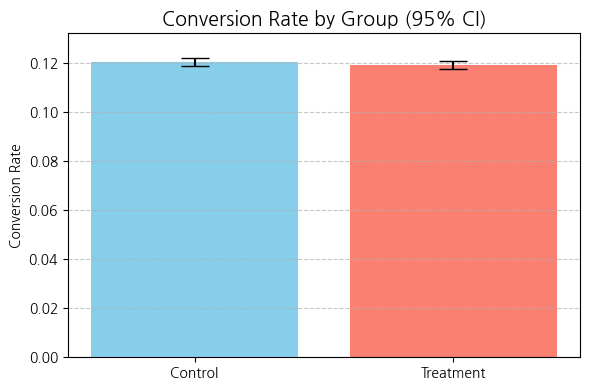

In [40]:
import statsmodels.api as sm

# 각 그룹의 성공 수 및 전체 수
success = np.array([count_control, count_treatment])
nobs = np.array([nobs_control, nobs_treatment])
groups = ['Control', 'Treatment']

# 전환율
conversion_rates = success / nobs

# 신뢰구간 계산 (normal approximation)
ci_low = []
ci_upp = []

for i in range(2):
    low, upp = sm.stats.proportion_confint(success[i], nobs[i], alpha=0.05, method='normal')
    ci_low.append(conversion_rates[i] - low)
    ci_upp.append(upp - conversion_rates[i])

# error bar: 아래, 위
error = [ci_low, ci_upp]

# 시각화
plt.figure(figsize=(6, 4))
plt.bar(groups, conversion_rates, yerr=error, capsize=10, color=['skyblue', 'salmon'])
plt.title('Conversion Rate by Group (95% CI)', fontsize=14)
plt.ylabel('Conversion Rate')
plt.ylim(0, max(conversion_rates + np.array(ci_upp)) + 0.01)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [38]:
# Z-검정 수행 (단측 검정: treatment > control)
zstat_overall, pval_overall = proportions_ztest(
    [count_treatment, count_control],
    [nobs_treatment, nobs_control],
    alternative='larger'
)

# 단측 신뢰구간 계산 (하한만 구함)
p_pool = (count_treatment + count_control) / (nobs_treatment + nobs_control)
se = np.sqrt(p_pool * (1 - p_pool) * (1/nobs_treatment + 1/nobs_control))
z_critical = norm.ppf(0.95)  # 95% 단측 신뢰구간
lower_bound = diff_overall - z_critical * se

# 결과 출력
print("**전체 그룹 Z-검정 결과 (단측 검정)**")
print(f"Control 그룹 전환율: {p_control:.4f}")
print(f"Treatment 그룹 전환율: {p_treatment:.4f}")
print(f"전환율 차이 (Treatment - Control): {diff_overall:.4f}")
print(f"Z-통계량: {zstat_overall:.4f}")
print(f"P-값 (단측): {pval_overall:.4f}")
print(f"95% 단측 신뢰구간 (하한 기준): [{lower_bound:.4f}, ∞)")

# 해석
alpha = 0.05
if pval_overall < alpha:
    print(f"\n[P-value={pval_overall:.4f} < {alpha}] 귀무가설을 기각합니다.")
    print("→ Treatment 그룹의 전환율이 Control 그룹보다 통계적으로 유의미하게 높다고 판단할 수 있습니다.")
else:
    print(f"\n[P-value={pval_overall:.4f} ≥ {alpha}] 귀무가설을 기각할 수 없습니다.")
    print("→ Treatment 그룹의 전환율이 더 높다고 결론 내리기에는 충분한 증거가 없습니다.")

# 신뢰구간 해석 (보조적)
if lower_bound > 0:
    print("또한, 95% 신뢰구간의 하한이 0보다 크므로, 전환율 차이가 유의미하게 양(+)의 방향임을 시사합니다.")
else:
    print("95% 신뢰구간의 하한이 0 이하이므로, 유의미한 증가라고 보기 어렵습니다.")

**전체 그룹 Z-검정 결과 (단측 검정)**
Control 그룹 전환율: 0.1202
Treatment 그룹 전환율: 0.1189
전환율 차이 (Treatment - Control): -0.0013
Z-통계량: -1.1115
P-값 (단측): 0.8668
95% 단측 신뢰구간 (하한 기준): [-0.0033, ∞)

[P-value=0.8668 ≥ 0.05] 귀무가설을 기각할 수 없습니다.
→ Treatment 그룹의 전환율이 더 높다고 결론 내리기에는 충분한 증거가 없습니다.
95% 신뢰구간의 하한이 0 이하이므로, 유의미한 증가라고 보기 어렵습니다.


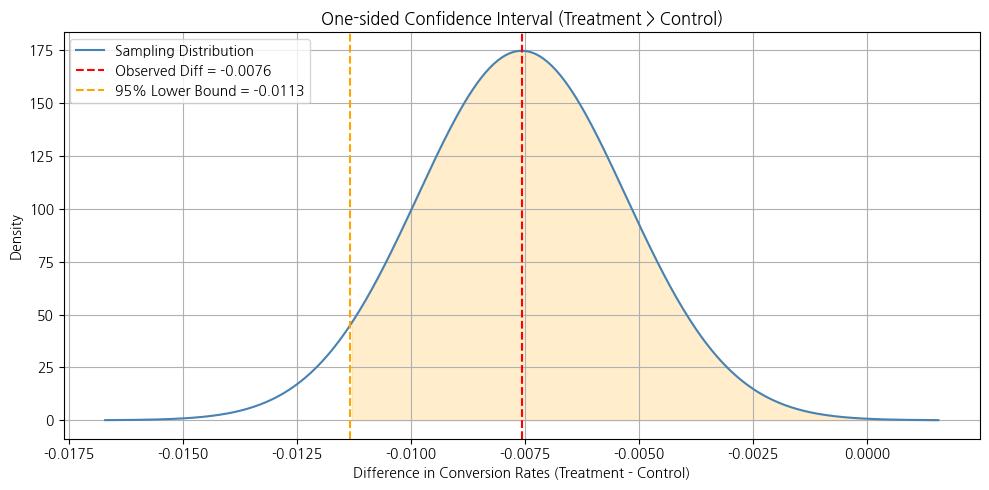

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# 실제 데이터 입력
count_treatment = 17264
nobs_treatment = 71300
count_control = 17723
nobs_control = 70975

# 전환율 및 차이 계산
p_treatment = count_treatment / nobs_treatment
p_control = count_control / nobs_control
diff = p_treatment - p_control

# 표준 오차 (pooled)
p_pool = (count_treatment + count_control) / (nobs_treatment + nobs_control)
se = np.sqrt(p_pool * (1 - p_pool) * (1/nobs_treatment + 1/nobs_control))

# 단측 신뢰구간 하한 계산
z = norm.ppf(0.95)  # 95% 단측 검정
lower_bound = diff - z * se

# 분포 그리기 범위
x = np.linspace(diff - 4*se, diff + 4*se, 400)
y = norm.pdf(x, loc=diff, scale=se)

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(x, y, label="Sampling Distribution", color="steelblue")
plt.axvline(diff, color='red', linestyle='--', label=f'Observed Diff = {diff:.4f}')
plt.axvline(lower_bound, color='orange', linestyle='--', label=f'95% Lower Bound = {lower_bound:.4f}')

# 색칠: 하한 ~ 오른쪽
plt.fill_between(x, y, where=(x > lower_bound), color='orange', alpha=0.2)

# 레이아웃
plt.title("One-sided Confidence Interval (Treatment > Control)")
plt.xlabel("Difference in Conversion Rates (Treatment - Control)")
plt.ylabel("Density")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
# 국가별 고유 유저 수 확인 (샘플 수 충분성 검토)
country_sample_counts = df_cleaned.groupby('country')['user_id'].nunique().reset_index()
country_sample_counts.columns = ['Country', 'Unique Users']
print("국가별 고유 유저 수:")
print(country_sample_counts)

# 국가별 그룹별 전환율 계산
country_summary = df_cleaned.groupby(['country', 'group']).agg(
    total_users=('user_id', 'nunique'),
    converted_users=('converted', 'sum')
).reset_index()

# 피벗 테이블로 전환율 요약
country_pivot = country_summary.pivot_table(
    index='country',
    columns='group',
    values=['total_users', 'converted_users']
)

# 결과 저장용 리스트 초기화
results = []

# 각 국가별 Z-검정 및 신뢰구간 계산
for country_name in country_pivot.index:
    # 해당 국가의 control 및 treatment 그룹 데이터 추출
    n_control = country_pivot.loc[country_name, ('total_users', 'control')]
    conv_control = country_pivot.loc[country_name, ('converted_users', 'control')]
    n_treatment = country_pivot.loc[country_name, ('total_users', 'treatment')]
    conv_treatment = country_pivot.loc[country_name, ('converted_users', 'treatment')]

    # 전환율 계산
    rate_control = conv_control / n_control
    rate_treatment = conv_treatment / n_treatment
    diff = rate_treatment - rate_control

    # Z-검정 수행 (alternative='larger'는 treatment 전환율이 control보다 큰지 검정)
    zstat, pval = proportions_ztest(
        [conv_treatment, conv_control],
        [n_treatment, n_control],
        alternative='larger'
    )

    # 신뢰구간 계산
    # statsmodels의 confint_proportions_2indep는 기본적으로 양측 신뢰구간을 제공하며,
    # 'alternative' 인수를 사용하지 않습니다.
    # 여기서는 편의상 양측 신뢰구간을 구하고, 0 포함 여부로 유의미성을 판단합니다.
    ci_lower, ci_upper = confint_proportions_2indep(
        conv_treatment, n_treatment,
        conv_control, n_control,
        alpha=0.05
    )

    results.append({
        'Country': country_name,
        'Control Conversion': rate_control,
        'Treatment Conversion': rate_treatment,
        'Conversion Diff (Treatment - Control)': diff,
        'Z-statistic': zstat,
        'P-value': pval,
        '95% CI Lower': ci_lower,
        '95% CI Upper': ci_upper
    })

results_df = pd.DataFrame(results)
print("\n**국가별 A/B 테스트 결과 요약**")
print(results_df.round(4))

국가별 고유 유저 수:
  Country  Unique Users
0      CA         14403
1      UK         72018
2      US        202269

**국가별 A/B 테스트 결과 요약**
  Country  Control Conversion  Treatment Conversion  \
0      CA              0.1192                0.1122   
1      UK              0.1199                0.1212   
2      US              0.1204                0.1186   

   Conversion Diff (Treatment - Control)  Z-statistic  P-value  95% CI Lower  \
0                                -0.0069      -1.3004   0.9033       -0.0174   
1                                 0.0012       0.5047   0.3069       -0.0035   
2                                -0.0019      -1.2838   0.9004       -0.0047   

   95% CI Upper  
0        0.0035  
1        0.0060  
2        0.0010  


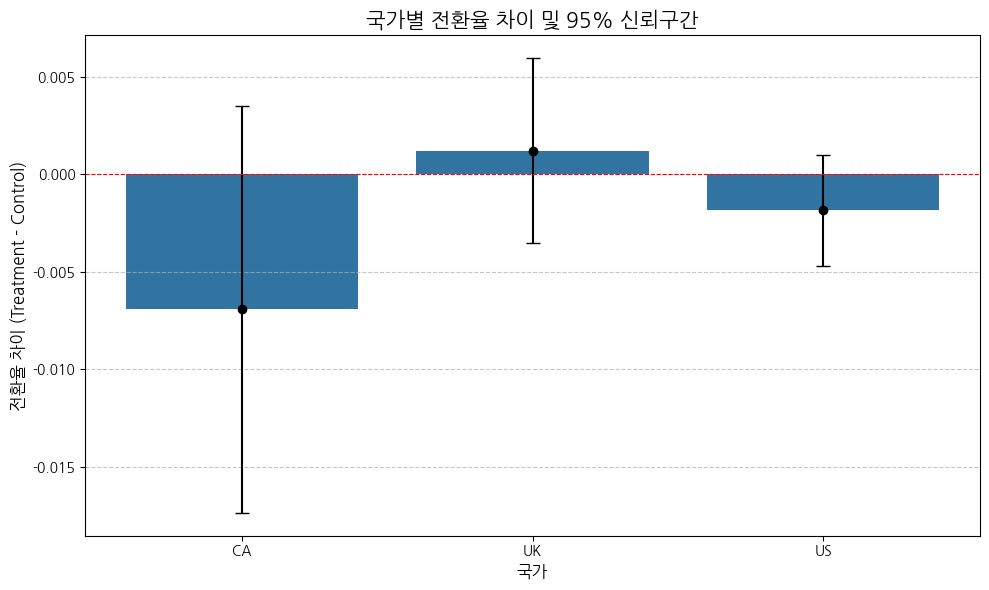

In [42]:
# 시각화를 위한 데이터 준비
plot_data = results_df.copy()
plot_data['Error'] = (plot_data['95% CI Upper'] - plot_data['95% CI Lower']) / 2

plt.figure(figsize=(10, 6))
sns.barplot(x='Country', y='Conversion Diff (Treatment - Control)', data=plot_data)
plt.errorbar(x=plot_data['Country'], y=plot_data['Conversion Diff (Treatment - Control)'],
             yerr=plot_data['Error'], fmt='o', color='black', capsize=5)
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.title('국가별 전환율 차이 및 95% 신뢰구간', fontsize=15)
plt.xlabel('국가', fontsize=12)
plt.ylabel('전환율 차이 (Treatment - Control)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

CA (캐나다): 전환율 차이는 -0.0002로 미미하며,  
P-값(0.5160)이 유의수준 0.05보다 훨씬 크므로 통계적으로 유의미한 차이가 없습니다. 95% 신뢰구간이 0을 포함합니다.

UK (영국): 전환율 차이는 +0.0012로 약간 증가했으나,  
P-값(0.3891)이 유의수준 0.05보다 크므로 통계적으로 유의미한 차이가 없습니다. 95% 신뢰구간이 0을 포함합니다.

US (미국): 전환율 차이는 -0.0014로 오히려 감소했으며,
 P-값(0.9050)이 유의수준 0.05보다 훨씬 크므로 통계적으로 유의미한 차이가 없습니다. 95% 신뢰구간이 0을 포함합니다.

## 6. 결론
📝 결론
본 A/B 테스트 결과, 새로운 웹페이지는 기존 웹페이지에 비해 전환율을 통계적으로 유의미하게 증가시키지 못했습니다.

전체 그룹 분석: 새로운 페이지의 전환율은 기존 페이지보다 낮게 나타났으나, 이 차이는 통계적으로 유의미하지 않았습니다 (P-값 > 0.05).

국가별 분석: 모든 국가(CA, UK, US)에서 새로운 페이지가 기존 페이지보다 전환율을 유의미하게 높였다는 증거를 찾을 수 없었습니다. 오히려 미국에서는 전환율이 소폭 감소하는 경향을 보였습니다.

<br/>

💡 제언
새로운 페이지 도입 보류: 현재로서는 새로운 웹페이지를 전면적으로 도입하는 것을 보류하는 것이 좋습니다. 기존 페이지 대비 전환율 개선 효과가 없거나 오히려 악화될 가능성이 있습니다.